# Feature Building!
This notebook will involve efforts to create new features out of the text data fields

### Get data from Kaggle, clean, and split

In [1]:
import re
import json
import csv
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import sys
#!{sys.executable} -m pip install textstat
from textstat.textstat import textstat

from subprocess import check_output
#from wordcloud import WordCloud, STOPWORDS

#ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from sklearn.grid_search import GridSearchCV 
from sklearn.pipeline import make_pipeline

%matplotlib inline
plt.style.use('bmh')

#1. Train Data
with open('../data/train.json') as fin:
    trainjson = json.load(fin)
train = pd.io.json.json_normalize(trainjson)
#2. Test Data
with open('../data/test.json') as fin:
    testjson = json.load(fin) 
test = pd.io.json.json_normalize(testjson)

print("Kaggle Train Shape:", train.shape)
print("Kaggle Test Shape:", test.shape)

train_labels_master = train[['requester_received_pizza']]
train_data_master = train[test.columns & train.columns]
train_only_data_master = train[train.columns[~train.columns.isin(test.columns)]].drop(['requester_received_pizza'], axis = 1)

train_data_master = train_data_master.assign(
    unix_timestamp_of_request = pd.to_datetime(
        train_data_master.unix_timestamp_of_request, unit = "s"),
    unix_timestamp_of_request_utc = pd.to_datetime(
        train_data_master.unix_timestamp_of_request_utc, unit = "s"))

# Isolate the text column for the training and dev dataframes
x_atrain, x_atest, y_train, y_test = train_test_split(
   train,
   train_labels_master.values.ravel(), test_size=0.29, random_state=0)

x_train = x_atrain[test.columns & train.columns]
x_test = x_atest[test.columns & train.columns]

print("Our Train Shape:", x_train.shape)
print("Our Test Shape:", x_test.shape)



C:\Users\benar\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\benar\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Kaggle Train Shape: (4040, 32)
Kaggle Test Shape: (1631, 17)
Our Train Shape: (2868, 17)
Our Test Shape: (1172, 17)


### Model report function

In [2]:
def model_report(title, y_test, predictions):

    """
    Output: Classification report, confusion matrix, and ROC curve
    """
    print(title)
    print("---------")
    print(classification_report(y_test, predictions))

    cm = metrics.confusion_matrix(y_test, predictions)
    plt.figure(figsize=(3,3))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy: {0}'.format(round(metrics.accuracy_score(y_test, predictions),2))
    plt.title(all_sample_title, size = 15)
    plt.show()
    
    fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Make features function

In [3]:
def make_features(vocab):
    # this function takes as input a string list of words
    # it outputs four np.arrays: 
    # 1. train data feature dealing with title text
    # 2. train data feature dealing with body text
    # 3. test data feature dealing with title text
    # 4. test data feature dealing with body text

    # initialize feature variables to 0
    train_feature_title = np.zeros(shape = (x_train.shape[0],1))
    train_feature_body = np.zeros(shape = (x_train.shape[0],1))
    test_feature_title = np.zeros(shape = (x_test.shape[0],1))
    test_feature_body = np.zeros(shape = (x_test.shape[0],1))

    # look through each training sample for occurences of vocab words
    for sample_row in range(x_train.shape[0]):
        title_text = str(x_train.request_title.iloc[sample_row]).lower()
        body_text = str(x_train.request_text_edit_aware.iloc[sample_row]).lower() 
    
        for word in vocab:
            if word in title_text:
                train_feature_title[sample_row] = 1
            if word in body_text:
                train_feature_body[sample_row] = 1            
        
    # look through each test sample for occurences of vocab words
    for sample_row in range(x_test.shape[0]):
        title_text = str(x_test.request_title.iloc[sample_row]).lower()
        body_text = str(x_test.request_text_edit_aware.iloc[sample_row]).lower()

        for word in vocab:
            if word in title_text:
                test_feature_title[sample_row] = 1
            if word in body_text:
                test_feature_body[sample_row] = 1

    return(train_feature_title, train_feature_body, test_feature_title, test_feature_body)

### 1. Real hunger
The idea here: People who literally don't have enough to eat.

In [4]:
vocab = ['pantry','shelter','homeless','nowhere','nothing']
train_hunger_title, train_hunger_body, test_hunger_title, test_hunger_body = make_features(vocab)


### 2. In-group features
The idea here: People who reference the reddit community and the lingo may be more sympathetic. 

In [5]:
vocab = ['roap', 'reddit']
train_ingroup_title, train_ingroup_body, test_ingroup_title, test_ingroup_body = make_features(vocab)
    
    

### 3. Student features
The idea here: Students may be sympathetic. Found that most student terms were unhelpful, but 'ramen' was a winner. 

In [6]:
vocab = ['ramen']
train_student_title, train_student_body, test_student_title, test_student_body = make_features(vocab)


### 4. 'You're a good person' features
The idea here: Words that emphasis the goodness of the giver. This replaces swears, which didn't serve as an indicator.

In [7]:
vocab = ['bless','generosity','kind','generous']
train_goodie_title, train_goodie_body, test_goodie_title, test_goodie_body = make_features(vocab)


### 5. Religious features
The idea here: I'm a good Christian, now buy me a pizza! This might have been the strongest feature. 

In [8]:
vocab = ['lord','prayer','savior','personal','saved','forgiven', 'mercy']
train_god_title, train_god_body, test_god_title, test_god_body ,= make_features(vocab)



### 6. Gratitude / politeness features
The idea here: What's the magic word?

In [9]:
vocab = ['please', 'thank', 'thanks']
train_polite_title, train_polite_body, test_polite_title, test_polite_body = make_features(vocab)


### 7. Expenses features
The idea here: Don't tell me your broke or poor (these were losers), tell me specific expenses. The rent is too damn high is still a winer!

In [10]:
vocab = ['rent','car']
train_expenses_title, train_expenses_body, test_expenses_title, test_expenses_body = make_features(vocab)

### 8. Hard work
The idea here: More sympathy when someone is trying.

In [11]:
vocab = ['work','job', 'tight']
train_work_title, train_work_body, test_work_title, test_work_body = make_features(vocab)

### 9. Lost job
The idea here: 'Fired' didn't help, but 'shitcanned' did.

In [12]:
vocab = ['birthday','wedding','married','engaged','bday','b-day','anniversary']
train_lostjob_title, train_lostjob_body, test_lostjob_title, test_lostjob_body = make_features(vocab)

### 10. More testing (from Mary's notebook)


In [13]:
vocab = ['hot','hawt','female','woman','chick','babe','lonely']
train_chicks_title, train_chicks_body, test_chicks_title, test_chicks_body = make_features(vocab)


### 11. Length of the titles / body text
The idea: People get tired of reading (text too long), or may need more details (text too short)

In [14]:
def small(data, size):
    
    # initialize feature variable to 0
    issmall = np.zeros(shape = (data.shape[0],1))
    counter = 0

    # look through each training sample for body text size
    for sample in data:
        if len(sample) < size:
            issmall[counter] = 1
        counter +=1
    return(issmall)
            
def large(data, size):
    
    # initialize feature variable to 0
    islarge = np.zeros(shape = (data.shape[0],1))
    counter = 0

    # look through each training sample for body text size
    for sample in data:
        if len(sample) > size:
            islarge[counter] = 1
        counter +=1
    return(islarge)

def charcount(data):
    
    # initialize feature variable to 0
    numchars = np.zeros(shape = (data.shape[0],1))
    counter = 0

    # look through each training sample and count the text length
    for sample in data:
        numchars[counter] = len(sample)
        counter +=1
        
    return(numchars)

def readable(data):

    # initialize feature variable to 0
    readability = np.zeros(shape = (data.shape[0],1))
    counter = 0

    # look through each training sample and get Flesch score
    for sample in data:
        try:
            readability[counter] = textstat.dale_chall_readability_score(str(sample))
        except:
            readability[counter] = 0
        counter +=1
        
    return(readability)

def readable2(data):

    # initialize feature variable to 0
    readability = np.zeros(shape = (data.shape[0],1))
    counter = 0

    # look through each training sample and get score
    for sample in data:
        try:
            readability[counter] = textstat.flesch_reading_ease(str(sample))
        except:
            readability[counter] = 0
        counter +=1
        
    return(readability)


### Fit model with added features!

Logistic Regression (baseline)
---------
             precision    recall  f1-score   support

      False       0.77      0.99      0.87       891
       True       0.68      0.06      0.11       281

avg / total       0.75      0.77      0.69      1172



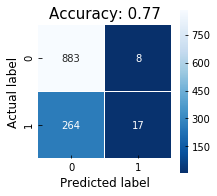

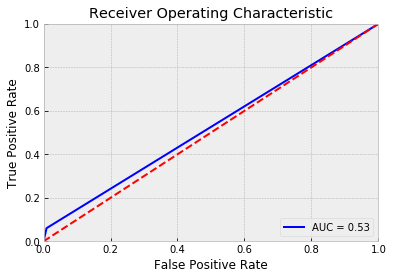

Logistic Regression (with engineered features)
---------
             precision    recall  f1-score   support

      False       0.78      0.99      0.87       891
       True       0.75      0.10      0.17       281

avg / total       0.77      0.78      0.70      1172



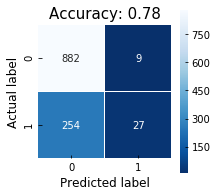

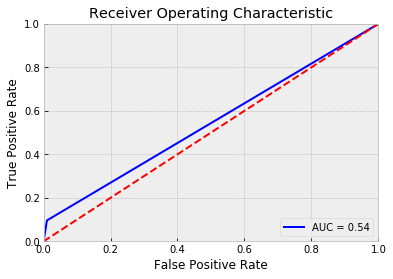

In [15]:
#Normalize all fields (numeric)
min_max_scaler = preprocessing.MinMaxScaler()
x_train_scaled = min_max_scaler.fit_transform(
    x_train.select_dtypes(include = ['float64', 'int64','datetime64[ns]']).apply(pd.to_numeric).values)
x_test_scaled = min_max_scaler.fit_transform(
    x_test.select_dtypes(include = ['float64', 'int64','datetime64[ns]']).apply(pd.to_numeric).values)

#Train Baseline Model
logisticRegr = LogisticRegression()
logisticRegr.fit(x_train_scaled, y_train)
predictions = logisticRegr.predict(x_test_scaled)

#Output Baseline model report
model_report("Logistic Regression (baseline)",y_test, predictions)

x_train_full = x_train_scaled.copy()
x_test_full = x_test_scaled.copy()

# add new bernoulli features to the train and test data
x_hunger_full = np.append(x_train_full, train_hunger_title, 1)
x_hunger_full = np.append(x_train_full, train_hunger_body, 1)
x_hunger_full = np.append(x_test_full, test_hunger_title, 1)
x_hunger_full = np.append(x_test_full, test_hunger_body, 1)
x_train_full = np.append(x_train_full, train_ingroup_title, 1) 
x_train_full = np.append(x_train_full, train_ingroup_body, 1) 
x_test_full = np.append(x_test_full, test_ingroup_title, 1) 
x_test_full = np.append(x_test_full, test_ingroup_body, 1) 
x_train_full = np.append(x_train_full, train_student_title, 1)  
x_train_full = np.append(x_train_full, train_student_body, 1) 
x_test_full = np.append(x_test_full, test_student_title, 1) 
x_test_full = np.append(x_test_full, test_student_body, 1) 
x_train_full = np.append(x_train_full, train_goodie_title, 1)
x_train_full = np.append(x_train_full, train_goodie_body, 1)
x_test_full = np.append(x_test_full, test_goodie_title, 1)
x_test_full = np.append(x_test_full, test_goodie_body, 1)
x_train_full = np.append(x_train_full, train_god_title, 1) 
x_train_full = np.append(x_train_full, train_god_body, 1) 
x_test_full = np.append(x_test_full, test_god_title, 1) 
x_test_full = np.append(x_test_full, test_god_body, 1) 
x_train_full = np.append(x_train_full, train_polite_title, 1) 
x_train_full = np.append(x_train_full, train_polite_body, 1)  
x_test_full = np.append(x_test_full, test_polite_title, 1) 
x_test_full = np.append(x_test_full, test_polite_body, 1) 
x_train_full = np.append(x_train_full, train_expenses_title, 1)
x_train_full = np.append(x_train_full, train_expenses_body, 1)
x_test_full = np.append(x_test_full, test_expenses_title, 1)
x_test_full = np.append(x_test_full, test_expenses_body, 1)
x_train_full = np.append(x_train_full, train_work_title, 1) 
x_train_full = np.append(x_train_full, train_work_body, 1) 
x_test_full = np.append(x_test_full, test_work_title, 1) 
x_test_full = np.append(x_test_full, test_work_body, 1) 
x_train_full = np.append(x_train_full, train_lostjob_title, 1) 
x_train_full = np.append(x_train_full, train_lostjob_body, 1) 
x_test_full = np.append(x_test_full, test_lostjob_title, 1) 
x_test_full = np.append(x_test_full, test_lostjob_body, 1) 
x_train_full = np.append(x_train_full, train_chicks_title, 1) 
x_train_full = np.append(x_train_full, train_chicks_body, 1) 
x_test_full = np.append(x_test_full, test_chicks_title, 1) 
x_test_full = np.append(x_test_full, test_chicks_body, 1) 

# add bernoulli features small / large
x_train_full = np.append(x_train_full, small(x_train.request_title,20), 1)
x_test_full = np.append(x_test_full, small(x_test.request_title,20), 1)

# add reading ease features
#x_train_full = np.append(x_train_full, min_max_scaler.fit_transform(readable(x_train.request_title)), 1)
#x_test_full = np.append(x_test_full, min_max_scaler.fit_transform(readable(x_test.request_title)), 1)
#x_train_full = np.append(x_train_full, min_max_scaler.fit_transform(readable2(x_train.request_text_edit_aware)), 1)
#x_test_full = np.append(x_test_full, min_max_scaler.fit_transform(readable2(x_test.request_text_edit_aware)), 1)

#Train new feature model
logisticRegr = LogisticRegression()
logisticRegr.fit(x_train_full, y_train)
predictions = logisticRegr.predict(x_test_full)

#Output new feature model report
model_report("Logistic Regression (with engineered features)",y_test, predictions)


### Vectorize the text features, boil down with SVD, add to the numeric data
This also runs a fairly slow for-loop going that searches for the optimum number of SVD components to choose. 

In [16]:
#Create Sparse matrix of words
count_vect = CountVectorizer() 
vect_train_body = count_vect.fit_transform(x_train.request_text_edit_aware)
vect_test_body = count_vect.transform(x_test.request_text_edit_aware)

def boildown (svd_comps):
    
    #Reduce the vectorized word feature to small number of numerical components
    svd_body = TruncatedSVD(n_components=svd_comps)
    svd_train_body = svd_body.fit_transform(vect_train_body)
    svd_test_body = svd_body.fit_transform(vect_test_body)

    #Add vectorized features to train and test
    x_train_newandvect = x_train_full.copy()
    x_test_newandvect = x_test_full.copy()
    for comp in range(svd_comps):
        x_train_newandvect = np.hstack((x_train_newandvect, svd_train_body[:,comp].reshape(-1,1)))
        x_test_newandvect = np.hstack((x_test_newandvect, svd_test_body[:,comp].reshape(-1,1)))

    #Train new feature + vectorized model
    logisticRegr = LogisticRegression()
    logisticRegr.fit(x_train_newandvect, y_train)
    predictions = logisticRegr.predict(x_test_newandvect)
    
    # compute auc
    fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    
    return(roc_auc, x_train_newandvect, x_test_newandvect)

best_auc = 0 # stores best value
best_svd_comps = 0 # stores index of best auc

print("Please wait while the best SVD component number is found...")

for svd_comps_body in range(130):
    auc, x_train_try, x_test_try = boildown(svd_comps_body)
    if auc > best_auc:
        best_auc = auc
        x_train_vect = x_train_try.copy()
        x_test_vect = x_test_try.copy()

print("The best AUC score for various SVD component numbers was", best_auc)

Please wait while the best SVD component number is found...
The best AUC score for various SVD component numbers was 0.5566938663024072


### Add imputed features (from Kevin's forays)
The training data has features that don't appear in the test data. No problem - we will impute the features for the test data using a random forest regressor. 

In [17]:
# all the features
cols_to_impute = ['number_of_downvotes_of_request_at_retrieval','number_of_upvotes_of_request_at_retrieval','request_number_of_comments_at_retrieval','requester_account_age_in_days_at_retrieval','requester_days_since_first_post_on_raop_at_retrieval','requester_number_of_comments_at_retrieval','requester_number_of_comments_in_raop_at_retrieval','requester_number_of_posts_at_retrieval','requester_number_of_posts_on_raop_at_retrieval','requester_upvotes_minus_downvotes_at_retrieval','requester_upvotes_plus_downvotes_at_retrieval']
    
col_count = 0 # keeps track of new columns to create
col_to_add = [] # stores list of columns to add

x_train_fullimputed = x_train_vect.copy()
x_test_fullimputed = x_test_vect.copy()

for col_to_predict in cols_to_impute:
        
    regr_multirf = RandomForestRegressor(max_depth=7,random_state=0)

    new_col = x_atrain[col_to_predict].values.reshape(-1,1)
    
    # scale train_labels
    min_max_scaler = preprocessing.MinMaxScaler()
    new_col_scaled = min_max_scaler.fit_transform(new_col)

    # impute                                    
    regr_multirf.fit(x_train_vect, new_col_scaled.ravel())
    predicted_col = regr_multirf.predict(x_test_vect).reshape(-1,1)
    
    # add the feature to both train and test
    x_train_fullimputed = np.hstack((x_train_fullimputed, new_col_scaled))
    x_test_fullimputed = np.hstack((x_test_fullimputed, predicted_col))
    
    col_count += 1



C:\Users\benar\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\benar\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\benar\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\benar\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\benar\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to floa

### Run the logistic regression
Optimize for C value for regularization.

Best C value for regularization {'C': 200.0}
Logistic Regression
---------
             precision    recall  f1-score   support

      False       0.79      0.89      0.84       891
       True       0.43      0.26      0.33       281

avg / total       0.70      0.74      0.71      1172



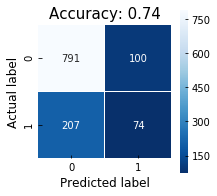

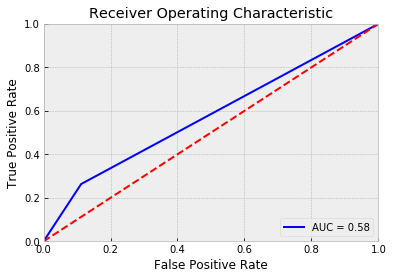

In [18]:
#Train Model
# all parameters not specified are set to their defaults
regularization = {'C': [50.0, 100.0, 200.0, 300.0, 400.0, 600.0, 800.0, 1000.0]} # testing revealed high range best
lr = LogisticRegression() #penalty = 'l2'  
optimum_lr = GridSearchCV(lr, regularization)
lr_fit = optimum_lr.fit(x_train_fullimputed, y_train)
predictions = lr_fit.predict(x_test_fullimputed)
print("Best C value for regularization", lr_fit.best_params_)

#Output model report
model_report("Logistic Regression",y_test, predictions)
